# Vanguard Portfolio Optimizer (using vanguard historical data)

## Initialization

In [1]:
%matplotlib inline

In [2]:
import requests
import json

import pandas as pd
import numpy as np
import requests_cache
import cvxpy as cp
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache('requests_cache', backend='sqlite')

In [4]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {
    "BOND": "red",
    "EQUITY": "green"
}
CUTOFF_YEAR = 2015

END_DATE = pd.to_datetime("2021-01-01")

## Get products descriptions

In [5]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)

def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json.values())
        .assign(
            fees=lambda x: x['OCF'].str.slice(0,-1).astype(float) / 100,
            assets= lambda x: x['assetAllocations'].apply(len_or),
            inceptionDate=lambda x: pd.to_datetime(x['inceptionDate'])
        )
        .reset_index(drop=True)
    )
    

raw_products_df = products_json_to_df(get_products())

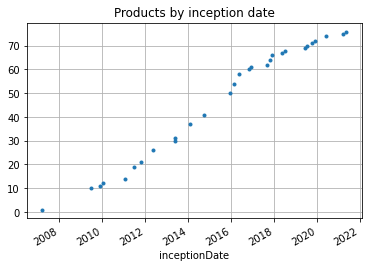

In [25]:
ax = raw_products_df.groupby('inceptionDate').size().sort_index().cumsum().plot(grid=True, style='.')
_ = ax.set_title('Products by inception date')

## Filter products

* Keep only "Accumulation" products (their dividends are automatically reinvsted)
* Remove actively managed products
* Remove ESG/SRI products (they are highly correlated to the non ESG/SRI products)
* Remove recently created products (not enough historical data)

In [7]:
products_df = (
    raw_products_df
    [
        lambda x: 
        (x['distributionStrategyType'] == 'ACCM')
        & x['assetCode'].isin(["BOND", "EQUITY"])
        & (x['managementType'] == 'INDEX')
        & ~x['name'].str.startswith('ESG ')
        & ~x['name'].str.startswith('SRI ')
        & (x['inceptionDate'].dt.year <= CUTOFF_YEAR)
    ]
    .reset_index(drop=True)
)

## Get products historical prices

In [8]:
histories = {}

for _, product in products_df.iterrows():
    port_id = product['portId']
    url = REQUEST_URL.format(
        port_id=port_id,
        start_date=product['inceptionDate'],
        end_date=END_DATE
    )
    request = requests.get(url)
    assert request.status_code == 200
    
    histories[port_id] = json.loads(request.text)



In [9]:
sedols = products_df.set_index('portId')['sedol'].to_dict()
dfs = []
for port_id, history in histories.items():
    df = (
        pd.DataFrame(history)
        .assign(
            date=lambda x: pd.to_datetime(x['date'], utc=True).dt.tz_localize(None).dt.normalize()
        )
        .drop(columns=['mmNavPrice'])
        .rename(columns={'navPrice': 'price'})
        .sort_values('date', ignore_index=True)
        .assign(
            sedol=sedols[port_id],
            day_return=lambda x: (x['price'] - x['price'].shift()) /  x['price'].shift(),
        )
    )
    dfs.append(df)
historical_df = pd.concat(dfs, ignore_index=True)    

## Explore products stats

In [10]:
pivoted_returns = (
    historical_df
        .pivot(index=['date'], columns=['sedol'], values=['day_return'])
        .droplevel(0, axis=1)
        .dropna(how='any')
        [lambda x: sorted(x.columns)]
)

In [11]:
yearly_returns_mean = ((1 + pivoted_returns.mean()) ** 252 -1).rename('yearly_return_mean')
yearly_returns_std = (pivoted_returns.std() * np.sqrt(252)).rename('yearly_return_std')
counts = pivoted_returns.count().rename('count')

stats = pd.concat([yearly_returns_mean, yearly_returns_std, counts], axis=1)

In [12]:
products_stats_df = products_df.join(stats, on='sedol')

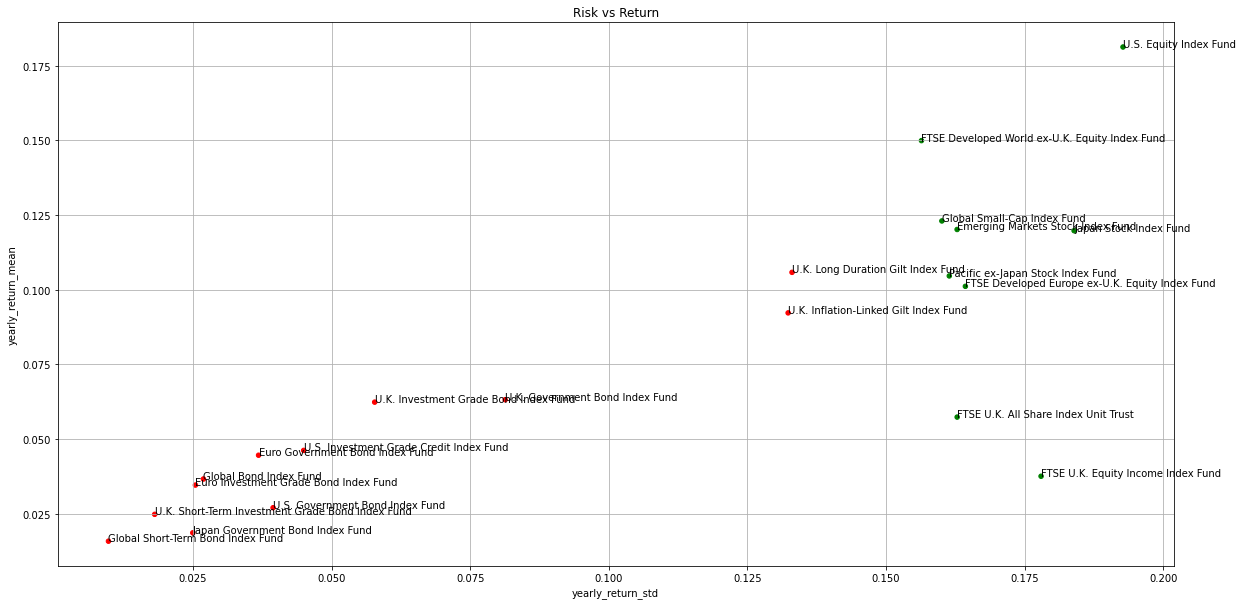

In [13]:
ax = (
    products_stats_df
    #.set_index('year_std')
    .plot.scatter(
        x='yearly_return_std',
        y='yearly_return_mean',
        grid=True,
        figsize=(20, 10),
        c=products_stats_df['assetCode'].map(ASSET_COLOURS)
    )
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(
    products_stats_df['yearly_return_std'], 
    products_stats_df['yearly_return_mean'], 
    products_stats_df['name'], 
    ax
)
_ = ax.set_title("Risk vs Return")

In [14]:
pivoted_prices = (
    historical_df
    .pivot(index='date', values='price', columns='sedol')
    .dropna(how='any')
)

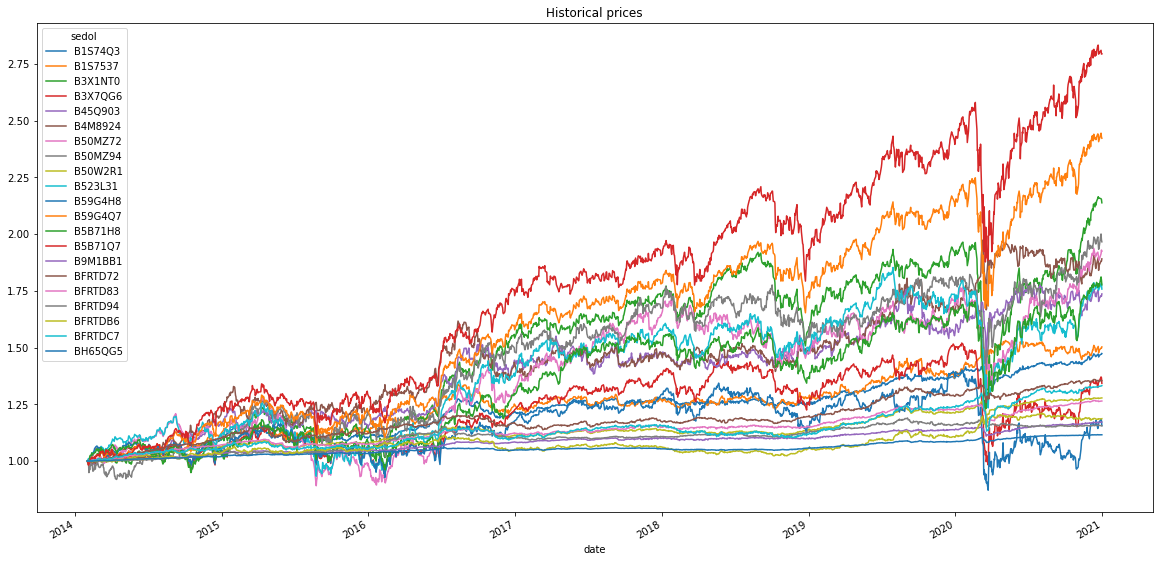

In [27]:
_ = (
    pivoted_prices
    .div(pivoted_prices.iloc[0], axis=1)
    .plot(figsize=(20,10), title='Historical prices')
)

## Prepare optimization inputs

In [16]:
covariance = (
        pivoted_returns.cov().sort_index()[lambda x: sorted(x.columns)]
)
expected_returns = pivoted_returns.mean()

In [17]:
class ProblemVariables:
    
    def __init__(self, expected_returns, covariance):
        
        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x
        
    def results(self):
        return self.ret.value, self.std()
    
    def std(self):
        return np.sqrt(self.vol.value)
        
    
    def year_std(self):
        return self.std() * np.sqrt(252)
    
    def year_return(self):
        return (1 + self.ret.value)**252 - 1
    
    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results['return'] = self.year_return()
        results['std'] = self.year_std()
        return pd.Series(results)
    
    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self
        
    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
              [
                  self.vol <= std_limit**2,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
        
    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()
        
        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
              [
                  self.ret >= return_limit,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
    
    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value
        
        return_values = np.linspace(min_return, max_return, points)
        
        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)

std_ptfs = ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)

## Plot results

In [18]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key='std'):
    assert key in ('std', 'return')
    mapping = products_df.set_index('sedol')['name'].to_dict()

    return (
        ptfs
        .drop(columns=['return' if key == 'std' else 'std'])
        .set_index('std' if key == 'std' else 'return')
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x:(x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot
        .area(figsize=[20,10], grid=True, legend='reverse')
    )

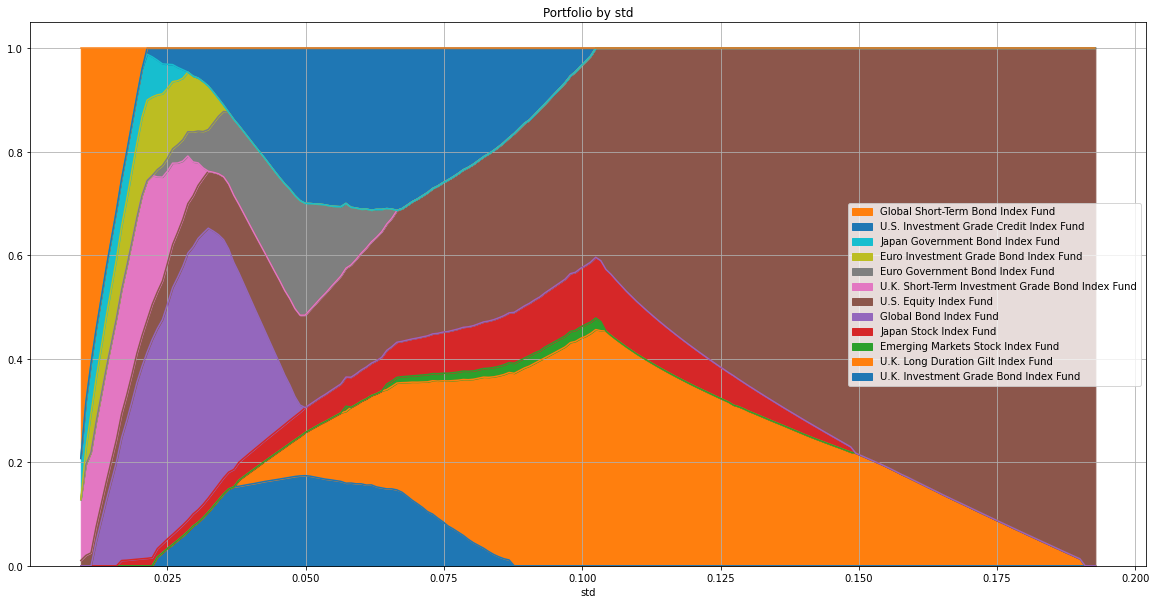

In [19]:
_ = plot_ptfs(std_ptfs, products_df, key='std').set_title("Portfolio by std")

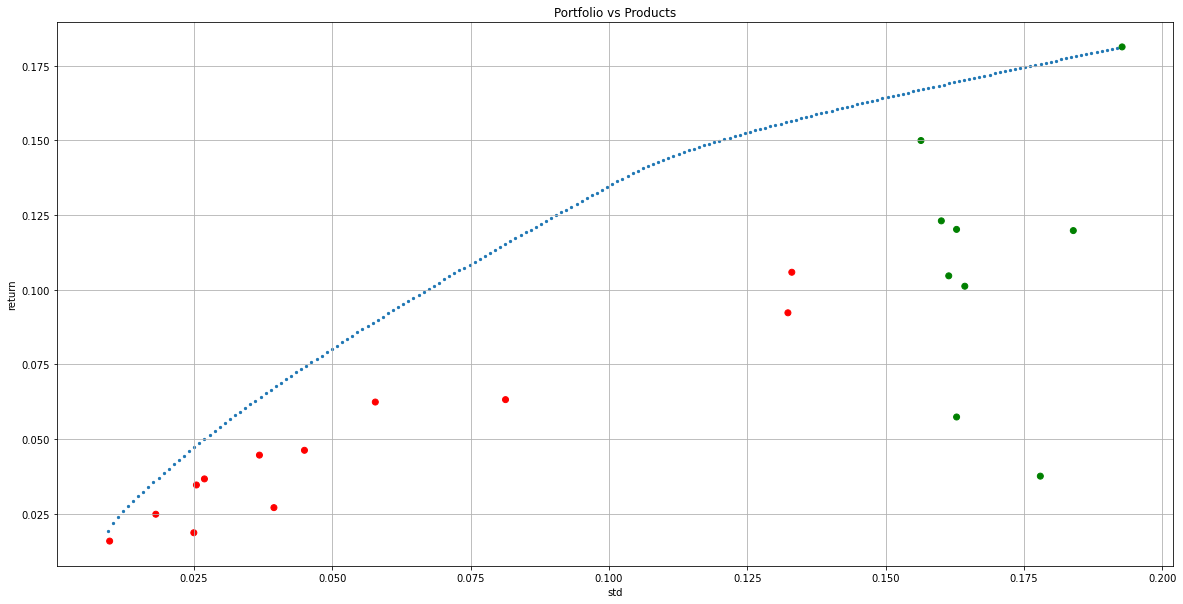

In [20]:
ax = (
    std_ptfs
    .plot.scatter(x='std', y='return', grid=True, marker='.', figsize=(20,10))
)
ax.scatter(
    x=products_stats_df['yearly_return_std'], 
    y=products_stats_df['yearly_return_mean'],
    c=products_stats_df['assetCode'].map(ASSET_COLOURS))
_ = ax.set_title('Portfolio vs Products')

# Appendix 1: identifying redundant products

In [21]:
marginal_vifs = (
    pd.Series(
        [
            variance_inflation_factor(pivoted_returns.values, i)
            for i in range(len(pivoted_returns.columns))
        ],
        index=pivoted_returns.columns
    )
    .sort_values()
    .rename('vif')
    .to_frame()
    .join(products_df.set_index('sedol')[['name']])
)
marginal_vifs

,vif,name
sedol,,
BFRTD94,1.281711,Japan Government Bond Index Fund
B9M1BB1,1.587600,U.K. Short-Term Investment Grade Bond Index Fund
BFRTD83,2.561496,Euro Investment Grade Bond Index Fund
BH65QG5,2.965567,Global Short-Term Bond Index Fund
BFRTDC7,3.169755,U.S. Investment Grade Credit Index Fund
B50MZ72,3.310818,Emerging Markets Stock Index Fund
BFRTD72,3.357467,Euro Government Bond Index Fund
B1S74Q3,3.400380,U.K. Investment Grade Bond Index Fund
B45Q903,3.514740,U.K. Inflation-Linked Gilt Index Fund


In [22]:
def calculate_vifs(pr):
    removed = {}
    for i in range(len(pr.columns) -1):
        vif = (
            pd.Series(
                [
                    variance_inflation_factor(pr.values, i)
                    for i in range(len(pr.columns))
                ],
                index=pr.columns
            )
            .sort_values()
            .rename('vif')
        )
        removed[vif.index[-1]] = vif.iloc[-1]
        
        pr = pr[lambda x: [c for c in x.columns if c not in removed]]
    removed[pr.columns[0]] = 1
    return pd.Series(removed, name='vif').sort_values()
                
recursive_vifs = (
    calculate_vifs(pivoted_returns)
    .to_frame()
    .rename_axis("sedol")
    .join(products_df.set_index('sedol')[['name']])
)
recursive_vifs

,vif,name
sedol,,
B59G4H8,1.000000,FTSE U.K. Equity Income Index Fund
BFRTDC7,1.000971,U.S. Investment Grade Credit Index Fund
BFRTD94,1.021158,Japan Government Bond Index Fund
B50MZ94,1.056454,Japan Stock Index Fund
B9M1BB1,1.176091,U.K. Short-Term Investment Grade Bond Index Fund
BFRTD72,1.353138,Euro Government Bond Index Fund
B5B71Q7,1.422049,U.S. Equity Index Fund
B45Q903,1.572531,U.K. Inflation-Linked Gilt Index Fund
B523L31,1.932243,Pacific ex-Japan Stock Index Fund


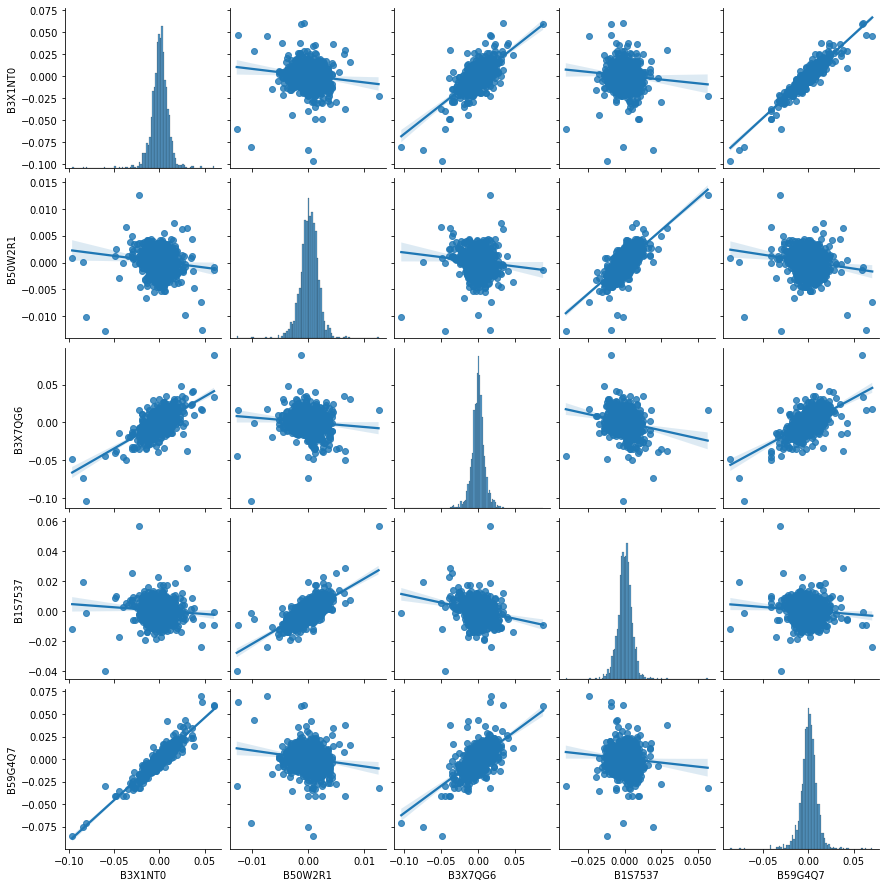

In [23]:
_ = sns.pairplot(pivoted_returns[recursive_vifs.index[-5:]], kind="reg")